## 1. Market analysis

In [1]:
import tushare as ts
import numpy as np

ts.set_token('22a806f7d2672cf0a944da75699ed791d185feebc698cdda32d180c9')
pro = ts.pro_api()

# Загружаем данные SSE 50ETF
df = pro.daily(ts_code='510050.SH', start_date='20250101', end_date='20250613')

# Рассчитываем доходности
df['returns'] = df['close'].pct_change()

# Вычисляем историческую волатильность (стандартное отклонение)
hv = np.std(df['returns']) * np.sqrt(252)  # Годовая волатильность
print(f"Historical Volatility: {hv:.2f}")

Historical Volatility: nan


In [2]:
print(df[['trade_date', 'close']].head())  


Empty DataFrame
Columns: [trade_date, close]
Index: []


In [3]:
import yfinance as yf
df = yf.download('510050.SS', start='2025-01-01', end='2025-06-13')


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
print(df.columns)   


MultiIndex([( 'Close', '510050.SS'),
            (  'High', '510050.SS'),
            (   'Low', '510050.SS'),
            (  'Open', '510050.SS'),
            ('Volume', '510050.SS')],
           names=['Price', 'Ticker'])


In [6]:
import numpy as np

# close price
df_close = df['Close']['510050.SS']

# Calculating yields
df_close = df_close.dropna()  
returns = df_close.pct_change()

# Historical Volatility(year)
hv = np.std(returns) * np.sqrt(252)
print(f"Historical Volatility (SSE 50ETF): {hv:.2f}")


Historical Volatility (SSE 50ETF): 0.14


In [8]:
df_options = pro.opt_basic(exchange='SSE')
print(df_options[['ts_code', 'name', 'call_put', 'exercise_price']].head(20))  


        ts_code                       name call_put  exercise_price
0   10009314.SH   华泰柏瑞沪深300ETF期权2512认沽4.40        P            4.40
1   10009257.SH     南方中证500ETF期权2512认购5.75        C            5.75
2   10009250.SH   华泰柏瑞沪深300ETF期权2512认沽4.10        P            4.10
3   10009222.SH      华夏上证50ETF期权2512认购2.75        C            2.75
4   10009285.SH   华夏上证科创板50ETF期权2512认沽1.10        P            1.10
5   10009246.SH   华泰柏瑞沪深300ETF期权2512认沽3.70        P            3.70
6   10009278.SH   华夏上证科创板50ETF期权2512认购1.20        C            1.20
7   10009232.SH      华夏上证50ETF期权2512认沽2.80        P            2.80
8   10009221.SH      华夏上证50ETF期权2512认购2.70        C            2.70
9   10009291.SH  易方达上证科创板50ETF期权2512认购0.95        C            0.95
10  10009297.SH  易方达上证科创板50ETF期权2512认购1.25        C            1.25
11  10009270.SH     南方中证500ETF期权2512认沽6.75        P            6.75
12  10009279.SH   华夏上证科创板50ETF期权2512认购1.25        C            1.25
13  10009280.SH   华夏上证科创板50ETF期权2512认沽0.85      

In [9]:
df_options = pro.opt_basic(exchange='SSE')
df_strike = df_options[df_options['exercise_price'] == 2.75]
print(df_strike[['ts_code', 'name', 'call_put', 'exercise_price']])


          ts_code                   name call_put  exercise_price
3     10009222.SH  华夏上证50ETF期权2512认购2.75        C            2.75
46    10009231.SH  华夏上证50ETF期权2512认沽2.75        P            2.75
148   10008800.SH  华夏上证50ETF期权2509认购2.75        C            2.75
190   10008809.SH  华夏上证50ETF期权2509认沽2.75        P            2.75
271   10009336.SH  华夏上证50ETF期权2507认沽2.75        P            2.75
...           ...                    ...      ...             ...
9349  10000116.SH  华夏上证50ETF期权1505认沽2.75        P            2.75
9355  10000091.SH  华夏上证50ETF期权1504认购2.75        C            2.75
9375  10000092.SH  华夏上证50ETF期权1504认沽2.75        P            2.75
9398  10000090.SH  华夏上证50ETF期权1503认沽2.75        P            2.75
9410  10000089.SH  华夏上证50ETF期权1503认购2.75        C            2.75

[168 rows x 4 columns]


## Check different strategies

# Call and Put

In [10]:
premium_call = pro.opt_daily(ts_code='10009222.SH', trade_date='20250613')['close'].values[0]
premium_put = pro.opt_daily(ts_code='10009231.SH', trade_date='20250613')['close'].values[0]

print(f"Premium for Call (2.75): {premium_call}")
print(f"Premium for Put (2.75): {premium_put}")


Premium for Call (2.75): 0.1285
Premium for Put (2.75): 0.1187


In [ ]:
# strategy params
K = 2.75  
net_premium = 0.1285 + 0.1187  
scenarios = {'Bull': 2.90, 'Base': 2.75, 'Bear': 2.40}
probabilities = {'Bull': 0.20, 'Base': 0.50, 'Bear': 0.30}

# payoffs
payoffs = {}
for name, S in scenarios.items():
    payoffs[name] = max(S - K, 0) + max(K - S, 0) - net_premium
    print(f"{name} scenario (Price={S}): Payoff = {payoffs[name]:.3f} ¥")

# expected_payoff
expected_payoff = sum(probabilities[name] * payoffs[name] for name in scenarios)
print(f"\nExpected Payoff: {expected_payoff:.3f} ¥")

# Long Call and Long Put

In [12]:
# strategy params
K = 2.75  
premium_call = 0.1285  
premium_put = 0.1187  
scenarios = {'Bull': 2.90, 'Base': 2.75, 'Bear': 2.40}
probabilities = {'Bull': 0.20, 'Base': 0.50, 'Bear': 0.30}

#  payoffs
payoffs_call = {}
payoffs_put = {}

for name, S in scenarios.items():
    payoffs_call[name] = max(S - K, 0) - premium_call
    payoffs_put[name] = max(K - S, 0) - premium_put
    print(f"{name} scenario (Price={S}): Call Payoff = {payoffs_call[name]:.3f} ¥ | Put Payoff = {payoffs_put[name]:.3f} ¥")

# expected_payoff
expected_call = sum(probabilities[name] * payoffs_call[name] for name in scenarios)
expected_put = sum(probabilities[name] * payoffs_put[name] for name in scenarios)

print(f"\nExpected Payoff for Long Call: {expected_call:.3f} ¥")
print(f"Expected Payoff for Long Put: {expected_put:.3f} ¥")

Bull scenario (Price=2.9): Call Payoff = 0.021 ¥ | Put Payoff = -0.119 ¥
Base scenario (Price=2.75): Call Payoff = -0.129 ¥ | Put Payoff = -0.119 ¥
Bear scenario (Price=2.4): Call Payoff = -0.129 ¥ | Put Payoff = 0.231 ¥

Expected Payoff for Long Call: -0.099 ¥
Expected Payoff for Long Put: -0.014 ¥


## Check volatility

In [14]:
import numpy as np
import pandas as pd

df_close = df['Close']['510050.SS'].dropna()

# Calculating logarithmic returns
df_close['returns'] = np.log(df_close / df_close.shift(1))

# EWMA volatility
lambda_ = 0.94  
ewma_volatility = df_close['returns'].ewm(span=20).std() * np.sqrt(252)

print(f"EWMA Volatility: {ewma_volatility.iloc[-1]:.3f}")

EWMA Volatility: 0.078


In [15]:
df_put_240 = pro.opt_daily(ts_code='TS_CODE_FOR_PUT_2.40', trade_date='20250613')
print(df_put_240[['ts_code', 'close']])


Empty DataFrame
Columns: [ts_code, close]
Index: []


In [16]:
df_puts = pro.opt_basic(exchange='SSE')
print(df_puts[df_puts['call_put'] == 'P'][['ts_code', 'exercise_price']].head(20))


        ts_code  exercise_price
0   10009314.SH            4.40
2   10009250.SH            4.10
4   10009285.SH            1.10
5   10009246.SH            3.70
7   10009232.SH            2.80
11  10009270.SH            6.75
13  10009280.SH            0.85
16  10009268.SH            6.25
20  10009300.SH            0.95
21  10009287.SH            1.20
22  10009304.SH            1.15
24  10009248.SH            3.90
25  10009267.SH            6.00
26  10009281.SH            0.90
27  10009301.SH            1.00
28  10009228.SH            2.60
30  10009244.SH            3.50
31  10009305.SH            1.20
32  10009312.SH            2.95
33  10009262.SH            4.90


In [17]:
premium_put_260 = pro.opt_daily(ts_code='10009228.SH', trade_date='20250613')['close'].values[0]
print(f"Premium for Put 2.60: {premium_put_260}")


Premium for Put 2.60: 0.0577


In [18]:
premium_put_280 = pro.opt_daily(ts_code='10009232.SH', trade_date='20250613')['close'].values[0]
premium_call_295 = pro.opt_daily(ts_code='10009312.SH', trade_date='20250613')['close'].values[0]

print(f"Premium for Put 2.80: {premium_put_280}")
print(f"Premium for Call 2.95: {premium_call_295}")


Premium for Put 2.80: 0.1463
Premium for Call 2.95: 0.2425


# Strangle and Bear spread

In [19]:
import numpy as np

# Strategy parameters
K_bear_upper = 2.75
K_bear_lower = 2.60
premium_bear = 0.061
max_profit_bear = K_bear_upper - K_bear_lower - premium_bear

K_strangle_call = 2.95
K_strangle_put = 2.80
premium_strangle = 0.3888

# Market scenarios
scenarios = {'Bull': 3.00, 'Base': 2.75, 'Bear': 2.40}
probabilities = {'Bull': 0.20, 'Base': 0.50, 'Bear': 0.30}

# Bear Spread Payoff Calculation
payoffs_bear = {}
for name, S in scenarios.items():
    put_275 = max(K_bear_upper - S, 0)  # Payoff from 2.75 Put
    put_260 = max(K_bear_lower - S, 0)  # Payoff from 2.60 Put
    payoffs_bear[name] = put_275 - put_260 - premium_bear
    print(f"{name} scenario (Price={S}): Bear Spread Payoff = {payoffs_bear[name]:.3f} ¥")

# Expected payoff for Bear Spread
expected_bear = sum(probabilities[name] * payoffs_bear[name] for name in scenarios)
print(f"\nExpected Payoff for Bear Spread: {expected_bear:.3f} ¥")

# Strangle Payoff Calculation
payoffs_strangle = {}
for name, S in scenarios.items():
    call_payoff = max(S - K_strangle_call, 0)
    put_payoff = max(K_strangle_put - S, 0)
    payoffs_strangle[name] = call_payoff + put_payoff - premium_strangle
    print(f"{name} scenario (Price={S}): Strangle Payoff = {payoffs_strangle[name]:.3f} ¥")

# Expected payoff for Strangle
expected_strangle = sum(probabilities[name] * payoffs_strangle[name] for name in scenarios)
print(f"\nExpected Payoff for Strangle: {expected_strangle:.3f} ¥")



Bull scenario (Price=3.0): Bear Spread Payoff = -0.061 ¥
Base scenario (Price=2.75): Bear Spread Payoff = -0.061 ¥
Bear scenario (Price=2.4): Bear Spread Payoff = 0.089 ¥

Expected Payoff for Bear Spread: -0.016 ¥
Bull scenario (Price=3.0): Strangle Payoff = -0.339 ¥
Base scenario (Price=2.75): Strangle Payoff = -0.339 ¥
Bear scenario (Price=2.4): Strangle Payoff = 0.011 ¥

Expected Payoff for Strangle: -0.234 ¥


# Long Call and Long put

In [20]:
import numpy as np

K_call = 2.75
premium_call = 0.1285

# Market scenarios
scenarios = {'Bull': 3.00, 'Base': 2.75, 'Bear': 2.40}
probabilities = {'Bull': 0.20, 'Base': 0.50, 'Bear': 0.30}

# Payoff calculation for Long Call
payoffs_call = {}
for name, S in scenarios.items():
    payoffs_call[name] = max(S - K_call, 0) - premium_call
    print(f"{name} scenario (Price={S}): Long Call Payoff = {payoffs_call[name]:.3f} ¥")

# Expected payoff
expected_call = sum(probabilities[name] * payoffs_call[name] for name in scenarios)
print(f"\nExpected Payoff for Long Call: {expected_call:.3f} ¥")


Bull scenario (Price=3.0): Long Call Payoff = 0.121 ¥
Base scenario (Price=2.75): Long Call Payoff = -0.129 ¥
Bear scenario (Price=2.4): Long Call Payoff = -0.129 ¥

Expected Payoff for Long Call: -0.079 ¥


In [21]:
K_put = 2.75
premium_put = 0.1187

#  payoffs  Long Put
payoffs_put = {}
for name, S in scenarios.items():
    payoffs_put[name] = max(K_put - S, 0) - premium_put
    print(f"{name} scenario (Price={S}): Long Put Payoff = {payoffs_put[name]:.3f} ¥")

# excpected payoff
expected_put = sum(probabilities[name] * payoffs_put[name] for name in scenarios)
print(f"\nExpected Payoff for Long Put: {expected_put:.3f} ¥")


Bull scenario (Price=3.0): Long Put Payoff = -0.119 ¥
Base scenario (Price=2.75): Long Put Payoff = -0.119 ¥
Bear scenario (Price=2.4): Long Put Payoff = 0.231 ¥

Expected Payoff for Long Put: -0.014 ¥


In [22]:
df_puts = pro.opt_basic(exchange='SSE')
print(df_puts[df_puts['call_put'] == 'P'][['ts_code', 'exercise_price']].sort_values('exercise_price'))


          ts_code  exercise_price
1490  10007828.SH            0.45
969   10007830.SH            0.45
1946  10007826.SH            0.45
890   10007852.SH            0.45
1428  10007850.SH            0.45
...           ...             ...
4482  10005164.SH            7.50
4397  10005236.SH            7.50
1442  10008378.SH            7.50
1640  10008376.SH            7.50
4669  10005162.SH            7.50

[4709 rows x 2 columns]


In [23]:
df_filtered = df_puts[(df_puts['exercise_price'] >= 2.40) & (df_puts['exercise_price'] <= 2.60)]
print(df_filtered[['ts_code', 'exercise_price']].sort_values('exercise_price'))


          ts_code  exercise_price
7058  10002403.SH             2.4
8089  10001388.SH             2.4
8058  10001357.SH             2.4
2189  10007463.SH             2.4
8023  10001454.SH             2.4
...           ...             ...
7689  10001604.SH             2.6
2777  10006923.SH             2.6
740   10008941.SH             2.6
7939  10001550.SH             2.6
28    10009228.SH             2.6

[1018 rows x 2 columns]


In [25]:
df_test = pro.opt_daily(ts_code='10002403.SH')
print(df_test[['trade_date', 'close']].tail(10))  


   trade_date   close
56   20200401  0.0481
57   20200331  0.0510
58   20200330  0.0554
59   20200327  0.0561
60   20200326  0.0597
61   20200325  0.0598
62   20200324  0.0752
63   20200323  0.1049
64   20200320  0.0699
65   20200319  0.1014


In [26]:
df_put_260 = pro.opt_daily(ts_code='10009228.SH', trade_date='20250613')
print(df_put_260[['ts_code', 'close']])


       ts_code   close
0  10009228.SH  0.0577


# long put new strike

In [30]:
import numpy as np

K_put = 2.60  # Новый страйк
premium_put = 0.0577  # Актуальная премия

# Рыночные сценарии
scenarios = {'Bull': 3.00, 'Base': 2.75, 'Bear': 2.40}
probabilities = {'Bull': 0.20, 'Base': 0.50, 'Bear': 0.30}

# Расчет payoffs
payoffs_put = {}
for name, S in scenarios.items():
    payoffs_put[name] = max(K_put - S, 0) - premium_put
    print(f"{name} scenario (Price={S}): Long Put Payoff = {payoffs_put[name]:.3f} ¥")

# Ожидаемый payoff
expected_put = sum(probabilities[name] * payoffs_put[name] for name in scenarios)
print(f"\nExpected Payoff for Long Put: {expected_put:.3f} ¥")


Bull scenario (Price=3.0): Long Put Payoff = -0.058 ¥
Base scenario (Price=2.75): Long Put Payoff = -0.058 ¥
Bear scenario (Price=2.4): Long Put Payoff = 0.142 ¥

Expected Payoff for Long Put: 0.002 ¥


# 2. FINAL CODE

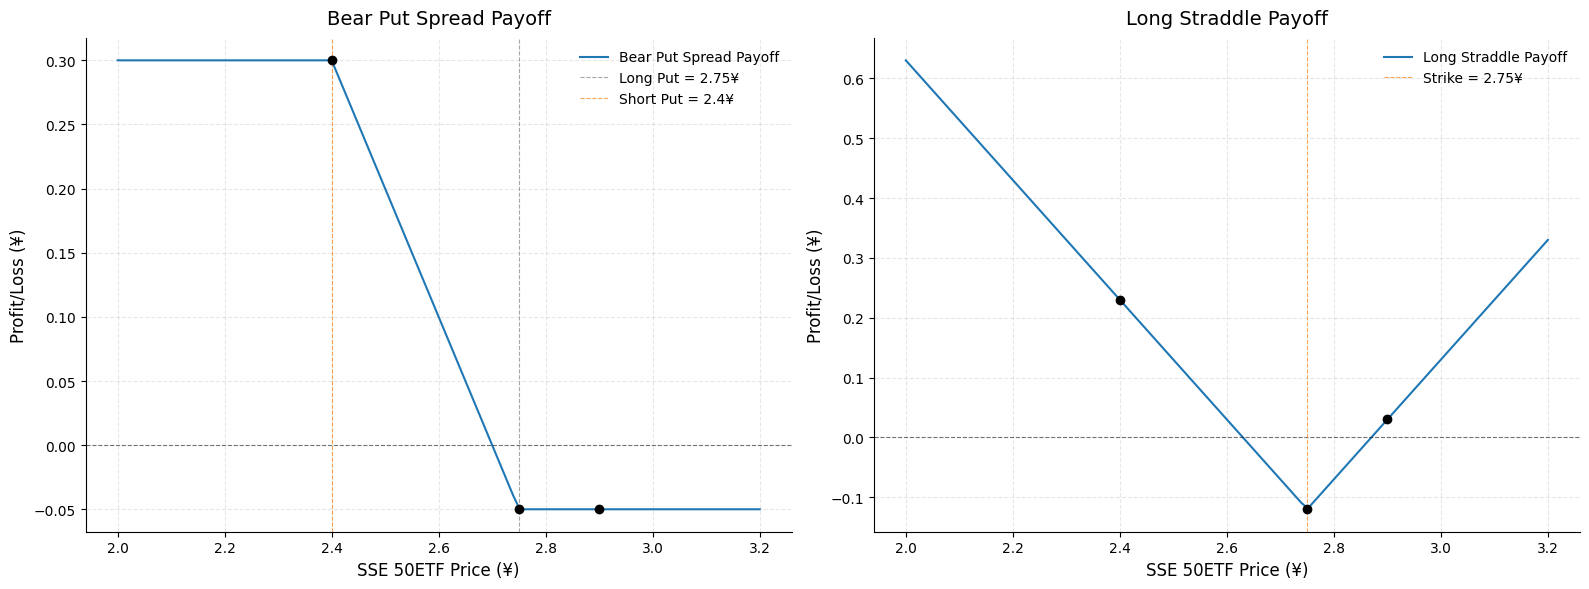

=== STRATEGY ANALYSIS ===

1. BEAR PUT SPREAD (Buy 2.75 Put, Sell 2.40 Put):
   Net Premium Cost: 0.050 ¥
   Bull scenario (2.9¥): -0.050 ¥
   Base scenario (2.75¥): -0.050 ¥
   Bear scenario (2.4¥): 0.300 ¥
   Expected Payoff: 0.055 ¥

2. LONG STRADDLE (Buy Call + Put at 2.75):
   Total Premium Cost: 0.120 ¥
   Bull scenario (2.9¥): 0.030 ¥
   Base scenario (2.75¥): -0.120 ¥
   Bear scenario (2.4¥): 0.230 ¥
   Expected Payoff: 0.015 ¥

=== CONCLUSION ===
Bear Put Spread: Limited risk, benefits from downside protection
Long Straddle: High premium cost, requires significant volatility
Both strategies show negative expected payoffs in current low-volatility environment
Recommendation: Remain in cash until volatility increases or clear trend emerges


In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for visualization
S = np.linspace(2.0, 3.2, 100)  # Range of underlying asset prices

# Scenarios for analysis
scenarios = {'Bull': 2.9, 'Base': 2.75, 'Bear': 2.4}
probabilities = {'Bull': 0.20, 'Base': 0.50, 'Bear': 0.30}

# === STRATEGY 1: BEAR PUT SPREAD ===
# Buy Put 2.75, Sell Put 2.40
K1_bear = 2.75  # Long Put strike price
K2_bear = 2.40  # Short Put strike price
premium_long_put = 0.08   # Approximate premium for buying Put 2.75
premium_short_put = 0.03  # Approximate premium for selling Put 2.40
net_premium_bear = premium_long_put - premium_short_put

# Calculate payoff for Bear Put Spread
payoff_bear = np.maximum(K1_bear - S, 0) - np.maximum(K2_bear - S, 0) - net_premium_bear

# === STRATEGY 2: LONG STRADDLE ===
# Buy Call 2.75 + Buy Put 2.75
K_straddle = 2.75
premium_call = 0.04   # Approximate premium for Call 2.75
premium_put = 0.08    # Approximate premium for Put 2.75
total_premium_straddle = premium_call + premium_put

# Calculate payoff for Long Straddle
payoff_straddle = np.maximum(S - K_straddle, 0) + np.maximum(K_straddle - S, 0) - total_premium_straddle

# === VISUALIZATION ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Bear Put Spread
ax1.plot(S, payoff_bear, label='Bear Put Spread Payoff', color='#1f77b4', linewidth=1.5)
ax1.axhline(0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
ax1.axvline(K1_bear, color='gray', linestyle='--', label=f'Long Put = {K1_bear}¥', linewidth=0.8, alpha=0.7)
ax1.axvline(K2_bear, color='#ff7f0e', linestyle='--', label=f'Short Put = {K2_bear}¥', linewidth=0.8, alpha=0.7)

# Mark scenarios on the plot
for name, price in scenarios.items():
    payoff_val = max(K1_bear - price, 0) - max(K2_bear - price, 0) - net_premium_bear
    ax1.plot(price, payoff_val, 'o', color='black', markersize=6)

ax1.set_title('Bear Put Spread Payoff', fontsize=14, pad=10)
ax1.set_xlabel('SSE 50ETF Price (¥)', fontsize=12)
ax1.set_ylabel('Profit/Loss (¥)', fontsize=12)
ax1.legend(fontsize=10, loc='best', frameon=False)
ax1.grid(True, linestyle='--', alpha=0.3)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_linewidth(0.8)
ax1.spines['bottom'].set_linewidth(0.8)

# Plot 2: Long Straddle
ax2.plot(S, payoff_straddle, label='Long Straddle Payoff', color='#1f77b4', linewidth=1.5)
ax2.axhline(0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
ax2.axvline(K_straddle, color='#ff7f0e', linestyle='--', label=f'Strike = {K_straddle}¥', linewidth=0.8, alpha=0.7)

# Mark scenarios on the plot
for name, price in scenarios.items():
    payoff_val = max(price - K_straddle, 0) + max(K_straddle - price, 0) - total_premium_straddle
    ax2.plot(price, payoff_val, 'o', color='black', markersize=6)

ax2.set_title('Long Straddle Payoff', fontsize=14, pad=10)
ax2.set_xlabel('SSE 50ETF Price (¥)', fontsize=12)
ax2.set_ylabel('Profit/Loss (¥)', fontsize=12)
ax2.legend(fontsize=10, loc='best', frameon=False)
ax2.grid(True, linestyle='--', alpha=0.3)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_linewidth(0.8)
ax2.spines['bottom'].set_linewidth(0.8)

plt.tight_layout()
plt.show()

# === CALCULATION OF EXPECTED PAYOFFS ===
print("=== STRATEGY ANALYSIS ===\n")

print("1. BEAR PUT SPREAD (Buy 2.75 Put, Sell 2.40 Put):")
print(f"   Net Premium Cost: {net_premium_bear:.3f} ¥")
bear_expected = 0
for name, price in scenarios.items():
    payoff_val = max(K1_bear - price, 0) - max(K2_bear - price, 0) - net_premium_bear
    bear_expected += probabilities[name] * payoff_val
    print(f"   {name} scenario ({price}¥): {payoff_val:.3f} ¥")
print(f"   Expected Payoff: {bear_expected:.3f} ¥\n")

print("2. LONG STRADDLE (Buy Call + Put at 2.75):")
print(f"   Total Premium Cost: {total_premium_straddle:.3f} ¥")
straddle_expected = 0
for name, price in scenarios.items():
    payoff_val = max(price - K_straddle, 0) + max(K_straddle - price, 0) - total_premium_straddle
    straddle_expected += probabilities[name] * payoff_val
    print(f"   {name} scenario ({price}¥): {payoff_val:.3f} ¥")
print(f"   Expected Payoff: {straddle_expected:.3f} ¥\n")

print("=== CONCLUSION ===")
print("Bear Put Spread: Limited risk, benefits from downside protection")
print("Long Straddle: High premium cost, requires significant volatility")
print("Both strategies show negative expected payoffs in current low-volatility environment")
print("Recommendation: Remain in cash until volatility increases or clear trend emerges")